# Impelemtación de Molodes de Machine Learning.


In [123]:
# instalación de paquetes
!pip install pandas
!pip install seaborn
!pip install scikit-learn
!pip install xgboost
!pip install xgboost --no-binary xgboost ## mac m1

ERROR: Invalid requirement: '##': Expected package name at the start of dependency specifier
    ##
    ^


In [101]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score,cross_validate
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score,classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier




import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go


import xgboost as xgb
from xgboost import XGBClassifier

In [9]:
# Leemos el dataset limpio
# Este dataset ya se encuentra analizado y preparado para aplicar modelos de Machine Learning, en caso de querer profundizar en el EDA y limpieza de datos, revisar el notebook "decoding-stress-with-ai-shap.ipynb"
# Para Obtener detalles de los feactores y la variable objetivo, revisar el notebook "decoding-stress-with-ai-shap.ipynb"

df = pd.read_csv('data_cleaned_to_ml.csv') 
df.head()

,Age,Gender,Marital_Status,Sleep_Duration,Sleep_Quality,Physical_Activity,Screen_Time,Caffeine_Intake,Alcohol_Intake,Smoking_Habit,...,Social_Interactions,Meditation_Practice,Exercise_Type,Blood_Pressure,Cholesterol_Level,Blood_Sugar_Level,Stress_Detection,sleep_hours,sleep_efficiency,Occupation_Group
0,30.0,1,0,7.0,4.0,2.0,4.0,1,0,0,...,5.0,1,1,120.0,180.0,90.0,0,9.0,7.777778,10
1,35.0,0,2,6.0,3.0,1.0,3.0,0,1,0,...,3.0,0,6,110.0,160.0,80.0,1,7.0,8.571429,0
2,40.0,1,1,7.0,4.0,2.0,4.0,1,0,0,...,5.0,1,4,130.0,200.0,100.0,2,9.0,7.777778,10
3,35.0,1,0,7.0,4.0,2.0,4.0,1,0,0,...,5.0,1,1,120.0,180.0,90.0,0,9.0,7.777778,10
4,29.0,0,0,8.0,5.0,3.0,2.0,1,0,0,...,4.0,1,6,110.0,180.0,90.0,0,8.0,10.000000,2


In [11]:
X = df.drop(columns=['Stress_Detection']) # Separamos los features de la variable objetivo
y = df['Stress_Detection'] # varible objetivo

# Segmentamos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

In [ ]:
# Clasificación con K-Nearest Neighbors (KNN)

In [12]:
# Estandarizar datos para calcular matriz de covarianza para distancia de Mahalanobis
scaler_for_vi = StandardScaler()
X_train_scaled = scaler_for_vi.fit_transform(X_train)
cov = np.cov(X_train_scaled, rowvar=False)
VI = np.linalg.inv(cov + 1e-6*np.eye(cov.shape[0]))  # Regularización para invertibilidad

print(f"\n✅ Matriz de covarianza inversa calculada: {VI.shape}")


✅ Matriz de covarianza inversa calculada: (21, 21)


In [13]:
# Definimos un pipeline de KNN que puede usar diferentes métricas y pesos

def knn_pipeline(metric, metric_params=None, weights="uniform", n_neighbors=5, 
                 cosine_norm=False, mahalanobis_VI=None):
    """
    Crea un pipeline de KNN con diferentes métricas y pesos.
    
    Args:
        metric: Métrica a usar ('minkowski', 'chebyshev', 'cosine', 'mahalanobis')
        metric_params: Parámetros adicionales para la métrica
        weights: 'uniform' o 'distance'
        n_neighbors: Número de vecinos
        cosine_norm: Si True, normaliza para coseno
        mahalanobis_VI: Matriz inversa de covarianza para Mahalanobis
    """
    steps = [("scaler", StandardScaler())]
    
    # Para coseno conviene normalizar (ángulo):
    if metric == "cosine" or cosine_norm:
        steps.append(("normalizer", Normalizer(norm="l2")))
    
    # Configurar KNN según métrica
    if metric == "mahalanobis":
        clf = KNeighborsClassifier(
            n_neighbors=n_neighbors, 
            weights=weights,
            metric=metric, 
            metric_params={"VI": mahalanobis_VI}
        )
    else:
        clf = KNeighborsClassifier(
            n_neighbors=n_neighbors, 
            weights=weights,
            metric=metric, 
            metric_params=metric_params
        )
    
    steps.append(("knn", clf))
    return Pipeline(steps)


In [17]:
# Creamos un configuracion para cada metrca de e iteramos sobre ellas apra evaluar cada una

# Configuraciones de métricas a evaluar
metric_configs = [
    ("L2 / uniform",   {"metric": "minkowski", "params": {"p": 2}, "weights": "uniform"}),
    ("L2 / distance",  {"metric": "minkowski", "params": {"p": 2}, "weights": "distance"}),
    ("L1 / uniform",   {"metric": "minkowski", "params": {"p": 1}, "weights": "uniform"}),
    ("L∞ / uniform",   {"metric": "chebyshev", "params": None,     "weights": "uniform"}),
    ("Coseno / uniform", {"metric": "cosine", "params": None, "weights": "uniform", "cosine_norm": True}),
    ("Mahalanobis / uniform", {"metric": "mahalanobis", "params": None, "weights": "uniform", "mahalanobis_VI": VI}),
]

# Evaluamos desde k=3 por defecto (k=1 tiende a sobreajustar)
# Si quieres incluir k=1 para comparación, cambia a range(1, 21)
k_range = range(3, 21)  
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Almacenar resultados
results = {}

for name, config in metric_configs:
    print(f"\n🔄 Evaluando: {name}")
    
    k_scores = []
    for k in k_range:
        # Crear pipeline con k específico
        if config["metric"] == "mahalanobis":
            pipe = knn_pipeline(
                config["metric"], 
                config["params"], 
                config["weights"], 
                n_neighbors=k,
                mahalanobis_VI=config["mahalanobis_VI"]
            )
        elif config.get("cosine_norm"):
            pipe = knn_pipeline(
                config["metric"], 
                config["params"], 
                config["weights"], 
                n_neighbors=k,
                cosine_norm=True
            )
        else:
            pipe = knn_pipeline(
                config["metric"], 
                config["params"], 
                config["weights"], 
                n_neighbors=k
            )
        
        # Validación cruzada
        scores = cross_val_score(
            pipe, X_train, y_train, 
            cv=skf, 
            scoring="accuracy", 
            n_jobs=-1
        )
        k_scores.append(scores.mean())
    
    # Guardar resultados
    best_k = k_range[np.argmax(k_scores)]
    best_score = max(k_scores)
    results[name] = {
        "k_scores": k_scores,
        "best_k": best_k,
        "best_score": best_score
    }
    
    print(f"   ✅ Mejor k: {best_k} | CV Accuracy: {best_score:.4f}")


🔄 Evaluando: L2 / uniform
   ✅ Mejor k: 3 | CV Accuracy: 0.8408

🔄 Evaluando: L2 / distance
   ✅ Mejor k: 3 | CV Accuracy: 0.8408

🔄 Evaluando: L2 / distance
   ✅ Mejor k: 4 | CV Accuracy: 0.8675

🔄 Evaluando: L1 / uniform
   ✅ Mejor k: 4 | CV Accuracy: 0.8675

🔄 Evaluando: L1 / uniform
   ✅ Mejor k: 3 | CV Accuracy: 0.8875

🔄 Evaluando: L∞ / uniform
   ✅ Mejor k: 3 | CV Accuracy: 0.8875

🔄 Evaluando: L∞ / uniform
   ✅ Mejor k: 3 | CV Accuracy: 0.7096

🔄 Evaluando: Coseno / uniform
   ✅ Mejor k: 3 | CV Accuracy: 0.7096

🔄 Evaluando: Coseno / uniform
   ✅ Mejor k: 3 | CV Accuracy: 0.8375

🔄 Evaluando: Mahalanobis / uniform
   ✅ Mejor k: 3 | CV Accuracy: 0.8375

🔄 Evaluando: Mahalanobis / uniform
   ✅ Mejor k: 3 | CV Accuracy: 0.8533
   ✅ Mejor k: 3 | CV Accuracy: 0.8533


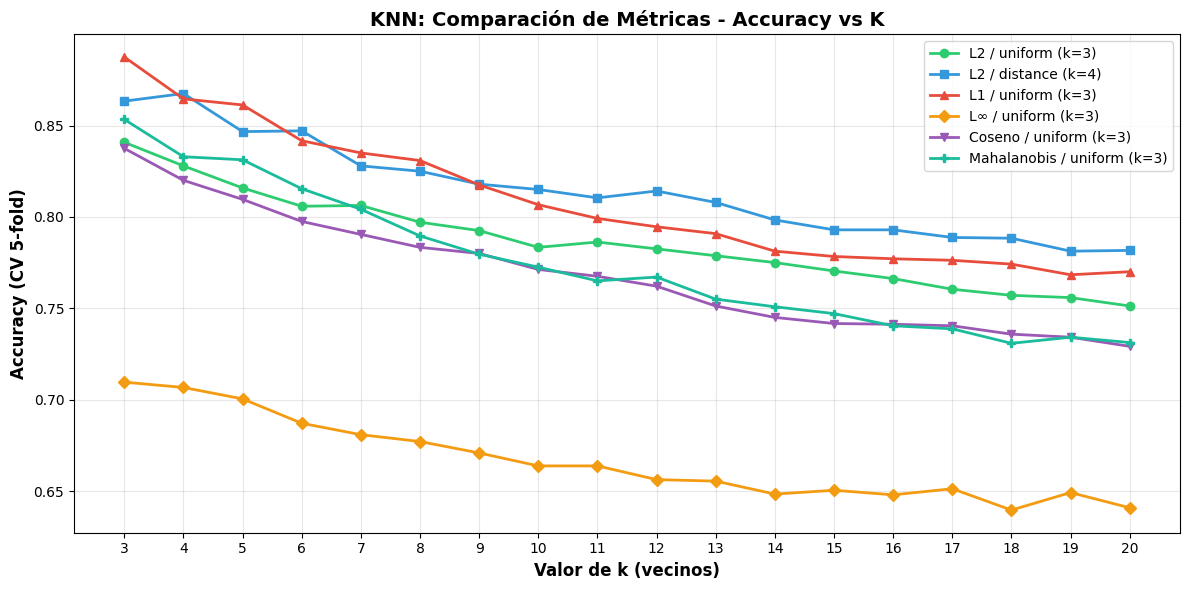

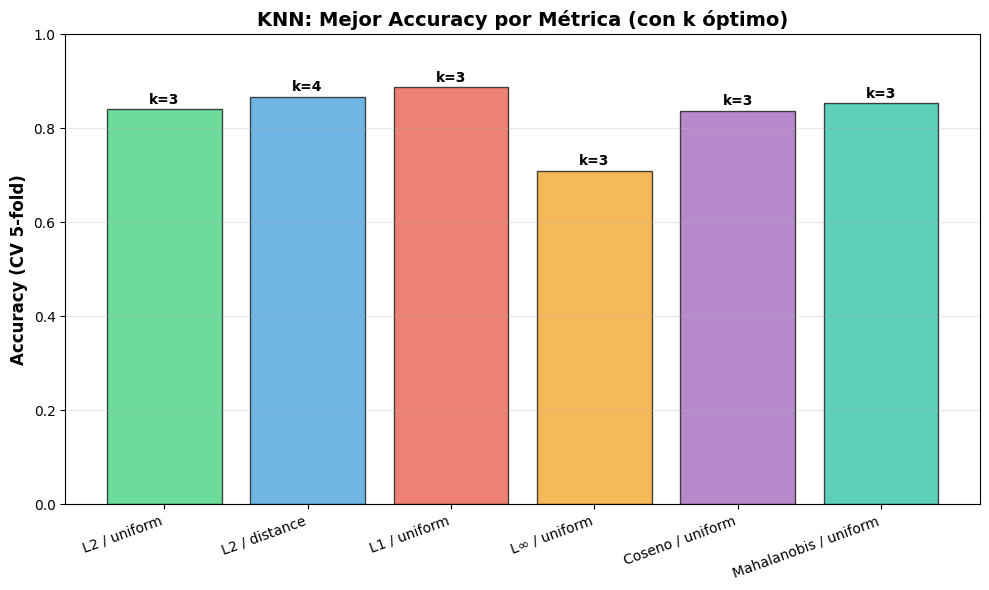

In [18]:
# Creamos una grafica para visualizar los resultados de K

# Gráfica 1: Líneas para todas las métricas
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12', '#9b59b6', '#1abc9c']
markers = ['o', 's', '^', 'D', 'v', 'P']

for (name, _), color, marker in zip(metric_configs, colors, markers):
    ax.plot(
        k_range, 
        results[name]["k_scores"], 
        marker=marker,
        linewidth=2,
        markersize=6,
        label=f'{name} (k={results[name] ["best_k"]})',
        color=color
    )

ax.set_xlabel('Valor de k (vecinos)', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy (CV 5-fold)', fontsize=12, fontweight='bold')
ax.set_title('KNN: Comparación de Métricas - Accuracy vs K', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xticks(k_range)
plt.tight_layout()
plt.show()

# Gráfica 2: Comparación de mejores K por métrica (barras)
fig, ax = plt.subplots(figsize=(10, 6))

names = [name for name, _ in metric_configs]
best_scores = [results[name]["best_score"] for name in names]
best_ks = [results[name]["best_k"] for name in names]

x_pos = np.arange(len(names))
bars = ax.bar(x_pos, best_scores, color=colors, alpha=0.7, edgecolor='black')

# Añadir valores de k sobre las barras
for i, (bar, k) in enumerate(zip(bars, best_ks)):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2., 
        height + 0.005,
        f'k={k}',
        ha='center', 
        va='bottom', 
        fontsize=10,
        fontweight='bold'
    )

ax.set_ylabel('Accuracy (CV 5-fold)', fontsize=12, fontweight='bold')
ax.set_title('KNN: Mejor Accuracy por Métrica (con k óptimo)', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(names, rotation=20, ha='right')
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [20]:

# Mostramos la mejor configuración de global, en nuestro caso y de acuerdo  a la grafica seria l1/uniform con un k=3

best_metric_name = max(results, key=lambda x: results[x]["best_score"])
best_metric_config = [c for name, c in metric_configs if name == best_metric_name][0]
best_k = results[best_metric_name]["best_k"]

print(f"\n🏆 Mejor configuración global:")
print(f"   • Métrica: {best_metric_name}")
print(f"   • k óptimo: {best_k}")
print(f"   • CV Accuracy: {results[best_metric_name]['best_score']:.4f}")


🏆 Mejor configuración global:
   • Métrica: L1 / uniform
   • k óptimo: 3
   • CV Accuracy: 0.8875


In [22]:
# Ahora vamos entrenar el modelo final con la mejor configuración encontrada.
# El codigo siguiente esta adaptando para funcionar con diferentes metricas L1, L2, Coseno y Mahalanobis

if best_metric_config["metric"] == "mahalanobis":
    final_pipe = knn_pipeline(
        best_metric_config["metric"], 
        best_metric_config["params"], 
        best_metric_config["weights"], 
        n_neighbors=best_k,
        mahalanobis_VI=best_metric_config["mahalanobis_VI"]
    )
elif best_metric_config.get("cosine_norm"):
    final_pipe = knn_pipeline(
        best_metric_config["metric"], 
        best_metric_config["params"], 
        best_metric_config["weights"], 
        n_neighbors=best_k,
        cosine_norm=True
    )
else:
    final_pipe = knn_pipeline(
        best_metric_config["metric"], 
        best_metric_config["params"], 
        best_metric_config["weights"], 
        n_neighbors=best_k
    )

In [26]:
# Ya definido la configuración del modelo final, procedemos a entrenar y evaluar en el conjunto de test

# Entrenar y predecir
final_pipe.fit(X_train, y_train)
y_pred_knn_final = final_pipe.predict(X_test)

# Métricas en test
test_accuracy_knn = accuracy_score(y_test, y_pred_knn_final)
test_precision_knn = precision_score(y_test, y_pred_knn_final, average='macro', zero_division=0)
test_recall_knn = recall_score(y_test, y_pred_knn_final, average='macro', zero_division=0)
test_f1_knn = f1_score(y_test, y_pred_knn_final, average='macro', zero_division=0)

print(f"\n✅ RESULTADOS EN CONJUNTO DE TEST:")
print("-" * 80)
print(f"Accuracy:  {test_accuracy_knn:.4f}")
print(f"Precision: {test_precision_knn:.4f}")
print(f"Recall:    {test_recall_knn:.4f}")
print(f"F1-Score:  {test_f1_knn:.4f}")



✅ RESULTADOS EN CONJUNTO DE TEST:
--------------------------------------------------------------------------------
Accuracy:  0.9067
Precision: 0.8948
Recall:    0.8892
F1-Score:  0.8919


c:\Users\rafael.guevara\Documents\Estudios 2025\Machine_Learning_Uc\.venv\Lib\site-packages\sklearn\neighbors\_classification.py:239: SyntaxWarning: Parameter p is found in metric_params. The corresponding parameter from __init__ is ignored.
  return self._fit(X, y)


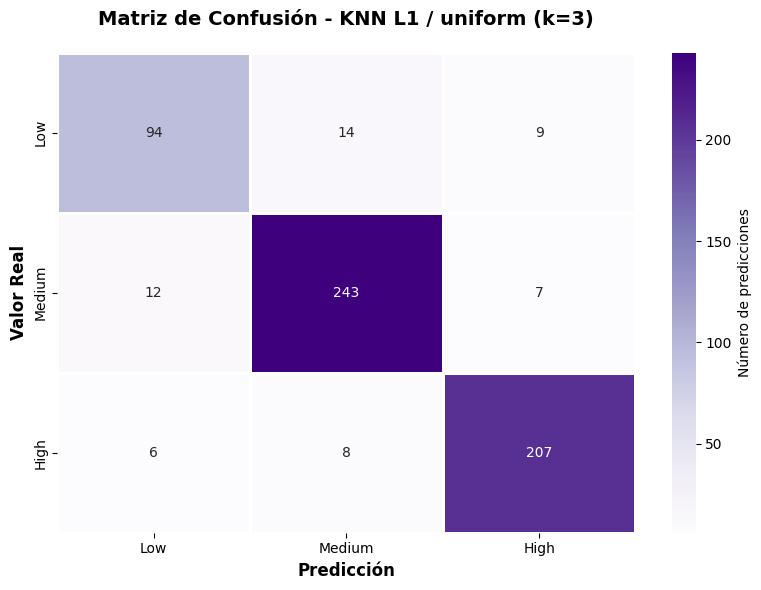

In [30]:
#Matriz de confusión de KNN con la mejor configuración

cm_knn_final = confusion_matrix(y_test, y_pred_knn_final)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_knn_final, 
    annot=True, 
    fmt='d', 
    cmap='Purples', 
    linewidths=2,
    xticklabels=['Low', 'Medium', 'High'],
    yticklabels=['Low', 'Medium', 'High'],
    cbar_kws={'label': 'Número de predicciones'}
)
plt.title(f'Matriz de Confusión - KNN {best_metric_name} (k={best_k})', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Predicción', fontsize=12, fontweight='bold')
plt.ylabel('Valor Real', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Clasificación con Support Vector Machine (SVM)

In [33]:
# Establecemos la configuración de los distintos tipos de kernels a evaluar
kernels_config = [
    ("Linear", {"kernel": "linear", "C": 1.0}),
    ("Poly (grado=3)", {"kernel": "poly", "C": 1.0, "degree": 3, "gamma": "scale", "coef0": 1.0}),
    ("RBF", {"kernel": "rbf", "C": 1.0, "gamma": "scale"}),
    ("Sigmoid", {"kernel": "sigmoid", "C": 1.0, "gamma": "scale", "coef0": 1.0}),
]

In [34]:
# Nos aseguramos de escalar los datos de entrada al modelo de estaforma buscamos que hirperplano sea optimo y no esta afectado por caracteristicas con escalas grandes
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [37]:
# Evaluación de cada kernel
kernel_results = {}
cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, params in kernels_config:
    print(f"\n🔄 Evaluando kernel: {name}")
    
    # Crear y entrenar modelo
    clf = SVC(**params, random_state=42)
    clf.fit(X_train_scaled, y_train)
    
    # Predicciones
    y_pred = clf.predict(X_test_scaled)
    
    # Métricas en test
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    
    # Validación cruzada
    cv_scores = cross_val_score(clf, X_train_scaled, y_train, cv=cv_stratified, 
                                scoring='accuracy', n_jobs=-1)
    
    # Guardar resultados
    kernel_results[name] = {
        'test_acc': acc,
        'test_prec': prec,
        'test_rec': rec,
        'test_f1': f1,
        'cv_acc_mean': cv_scores.mean(),
        'cv_acc_std': cv_scores.std(),
        'n_support': clf.support_.shape[0] if hasattr(clf, 'support_') else None
    }
    
    print(f"   ✅ Test Accuracy: {acc:.4f}")
    print(f"   ✅ CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
    if kernel_results[name]['n_support']:
        print(f"   📊 Support Vectors: {kernel_results[name]['n_support']}")




🔄 Evaluando kernel: Linear
   ✅ Test Accuracy: 0.6667
   ✅ CV Accuracy: 0.6562 (+/- 0.0260)
   📊 Support Vectors: 1706

🔄 Evaluando kernel: Poly (grado=3)
   ✅ Test Accuracy: 0.8317
   ✅ CV Accuracy: 0.8200 (+/- 0.0339)
   📊 Support Vectors: 1304

🔄 Evaluando kernel: RBF
   ✅ Test Accuracy: 0.7817
   ✅ CV Accuracy: 0.7921 (+/- 0.0454)
   📊 Support Vectors: 1586

🔄 Evaluando kernel: Sigmoid
   ✅ Test Accuracy: 0.3750
   ✅ CV Accuracy: 0.4150 (+/- 0.0229)
   📊 Support Vectors: 1688


In [40]:
# Visualizamos los resultados obtenidos de cada evaluación de kernels

# Tabla comparativa
comparison_kernels = pd.DataFrame(kernel_results).T
print(comparison_kernels.round(4))

# Gráfica comparativa
fig = go.Figure()

metrics = ['test_acc', 'test_prec', 'test_rec', 'test_f1']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#2ecc71', '#f39c12', "#886e6b"]

for metric, name, color in zip(metrics, metric_names, colors):
    fig.add_trace(go.Bar(
        name=name,
        x=list(kernel_results.keys()),
        y=[kernel_results[k][metric] for k in kernel_results.keys()],
        marker_color=color,
        text=[f"{kernel_results[k][metric]:.3f}" for k in kernel_results.keys()],
        textposition='auto'
    ))

fig.update_layout(
    title='Comparación de Kernels SVM - Métricas en Test',
    xaxis_title='Kernel',
    yaxis_title='Score',
    barmode='group',
    height=500,
    yaxis_range=[0, 1]
)

fig.show()

                test_acc  test_prec  test_rec  test_f1  cv_acc_mean  \
Linear            0.6667     0.6515    0.6109   0.6190       0.6562   
Poly (grado=3)    0.8317     0.8328    0.7908   0.8050       0.8200   
RBF               0.7817     0.7945    0.7291   0.7460       0.7921   
Sigmoid           0.3750     0.3718    0.3618   0.3628       0.4150   

                cv_acc_std  n_support  
Linear              0.0130     1706.0  
Poly (grado=3)      0.0170     1304.0  
RBF                 0.0227     1586.0  
Sigmoid             0.0114     1688.0  


In [43]:
# Implementamos Grid Search para optimizar hiperparámetros del mejor kernel encontrado (RBF)

# Pipeline con escalado y SVM
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(random_state=42))
])


# Grid de hiperparámetros (enfocado en RBF y Linear)
param_grid = [
    # RBF kernel
    {
        'svm__kernel': ['rbf'],
        'svm__C': [0.1, 1, 10, 100],
        'svm__gamma': ['scale', 'auto', 0.01, 0.1, 1.0]
    },
    # Linear kernel
    {
        'svm__kernel': ['linear'],
        'svm__C': [0.1, 1, 10, 100]
    },
    # Poly kernel
    {
        'svm__kernel': ['poly'],
        'svm__degree': [2, 3, 4],
        'svm__C': [0.1, 1, 10],
        'svm__gamma': ['scale', 'auto']
    }
]

print("🔍 Iniciando Grid Search...")
print(f"   • Búsqueda en {sum(len(g['svm__C']) * (len(g.get('svm__gamma', [1]))) * len(g.get('svm__degree', [1])) for g in param_grid)} combinaciones")
print(f"   • Validación cruzada: 5-fold estratificado")

# Grid Search
grid_search_svm = GridSearchCV(
    pipeline_svm,
    param_grid,
    cv=cv_stratified,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search_svm.fit(X_train, y_train)

print("\n✅ Grid Search completado!")
print(f"   🏆 Mejores parámetros: {grid_search_svm.best_params_}")
print(f"   📊 Mejor CV Score: {grid_search_svm.best_score_:.4f}")

🔍 Iniciando Grid Search...
   • Búsqueda en 42 combinaciones
   • Validación cruzada: 5-fold estratificado
Fitting 5 folds for each of 42 candidates, totalling 210 fits

✅ Grid Search completado!
   🏆 Mejores parámetros: {'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
   📊 Mejor CV Score: 0.8812


In [48]:
# Implementamos el Modelo SVM con los mejores hiperparámetros encontrados y evaluamos en el conjunto de test. Entrenamos y predecimos


# Crear pipeline con los mejores parámetros encontrados
best_svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(
        C=10, 
        gamma=0.1, 
        kernel='rbf',
        random_state=42,
        probability=True  # Para poder usar predict_proba si es necesario
    ))
])


# Entrenar el modelo con los mejores parámetros
print("Entrenando modelo SVM...")
best_svm_pipeline.fit(X_train, y_train)

# Realizar predicciones
print("Realizando predicciones en conjunto de test...")
y_pred_svm_best = best_svm_pipeline.predict(X_test)

# Calcular métricas
svm_best_accuracy = accuracy_score(y_test, y_pred_svm_best)
svm_best_precision = precision_score(y_test, y_pred_svm_best, average='macro', zero_division=0)
svm_best_recall = recall_score(y_test, y_pred_svm_best, average='macro', zero_division=0)
svm_best_f1 = f1_score(y_test, y_pred_svm_best, average='macro', zero_division=0)


Entrenando modelo SVM...
Realizando predicciones en conjunto de test...


In [51]:

print("\n" + "="*80)
print("📈 RESULTADOS DEL MODELO SVM OPTIMIZADO EN CONJUNTO DE TEST")
print("="*80)
print(f"Accuracy:  {svm_best_accuracy:.4f}")
print(f"Precision: {svm_best_precision:.4f}")
print(f"Recall:    {svm_best_recall:.4f}")
print(f"F1-Score:  {svm_best_f1:.4f}")

# Reporte de clasificación detallado
print("\n📋 REPORTE DE CLASIFICACIÓN DETALLADO:")
print("="*80)
print(classification_report(y_test, y_pred_svm_best, target_names=['Low', 'Medium', 'High']))


📈 RESULTADOS DEL MODELO SVM OPTIMIZADO EN CONJUNTO DE TEST
Accuracy:  0.9000
Precision: 0.9040
Recall:    0.8789
F1-Score:  0.8893

📋 REPORTE DE CLASIFICACIÓN DETALLADO:
              precision    recall  f1-score   support

         Low       0.92      0.78      0.84       117
      Medium       0.89      0.93      0.91       262
        High       0.90      0.93      0.91       221

    accuracy                           0.90       600
   macro avg       0.90      0.88      0.89       600
weighted avg       0.90      0.90      0.90       600



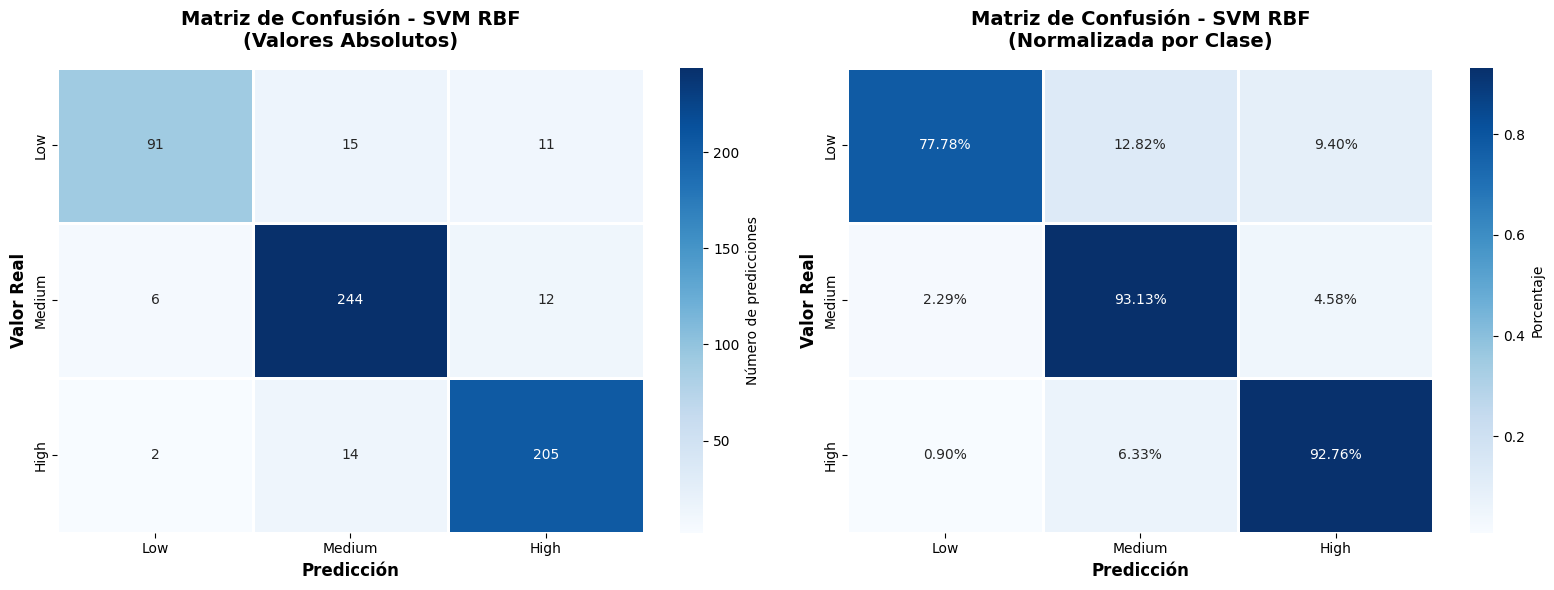

In [52]:
# Visualización de los resultados en matriz de confusión
cm_svm_best = confusion_matrix(y_test, y_pred_svm_best)

# Visualización de la matriz de confusión
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Matriz de confusión con valores absolutos
sns.heatmap(
    cm_svm_best, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    linewidths=2,
    xticklabels=['Low', 'Medium', 'High'],
    yticklabels=['Low', 'Medium', 'High'],
    cbar_kws={'label': 'Número de predicciones'},
    ax=axes[0]
)
axes[0].set_title('Matriz de Confusión - SVM RBF\n(Valores Absolutos)', 
                  fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Predicción', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Valor Real', fontsize=12, fontweight='bold')

# Matriz de confusión normalizada (porcentajes)
cm_normalized = cm_svm_best.astype('float') / cm_svm_best.sum(axis=1)[:, np.newaxis]
sns.heatmap(
    cm_normalized, 
    annot=True, 
    fmt='.2%', 
    cmap='Blues', 
    linewidths=2,
    xticklabels=['Low', 'Medium', 'High'],
    yticklabels=['Low', 'Medium', 'High'],
    cbar_kws={'label': 'Porcentaje'},
    ax=axes[1]
)
axes[1].set_title('Matriz de Confusión - SVM RBF\n(Normalizada por Clase)', 
                  fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Predicción', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Valor Real', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

#Implementación de XgBoost

In [57]:
# Configuramos y entrenamos el modelo XGBoost para clasificación multiclase

xgb_model = xgb.XGBClassifier(
    n_estimators=200,           # numero de árboles
    max_depth=6,                # profundidad max de cada árbol
    learning_rate=0.1,          # tasa de aprendizaje
    subsample=0.8,              # fracción de muestras para cada árbol
    colsample_bytree=0.8,       # fracción de features para cada árbol
    objective='multi:softmax',  # clasificación multiclase
    num_class=3,                # 3 clases (Low, Medium, High)
    random_state=42,
    eval_metric='mlogloss',     # Métrica de evaluación
    tree_method='hist',         # Método de construcción de árboles
    enable_categorical=False
)

xgb_model.fit(
    X_train, 
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

,objective,'multi:softmax'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [58]:
# Entrenado el modelo procedemos a  realizar las predicciones en el conjunto de test y mostramos las metricas obtenidas

print("\n🎯 Realizando predicciones...")
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)

# Calcular métricas
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_precision = precision_score(y_test, y_pred_xgb, average='macro', zero_division=0)
xgb_recall = recall_score(y_test, y_pred_xgb, average='macro', zero_division=0)
xgb_f1 = f1_score(y_test, y_pred_xgb, average='macro', zero_division=0)

print("\n" + "="*80)
print("📈 RESULTADOS DEL MODELO XGBOOST EN CONJUNTO DE TEST")
print("="*80)
print(f"Accuracy:  {xgb_accuracy:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall:    {xgb_recall:.4f}")
print(f"F1-Score:  {xgb_f1:.4f}")



🎯 Realizando predicciones...

📈 RESULTADOS DEL MODELO XGBOOST EN CONJUNTO DE TEST
Accuracy:  0.8800
Precision: 0.8843
Recall:    0.8550
F1-Score:  0.8667


In [75]:
# Aplicamos validacion cruzada con 5 folds para evaluar la estabilidad del modelo XGBoost, 5 folds es un buen compromiso entre sesgo y varianza

cv_scores_xgb = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

print("✅ Resultados de validación cruzada:")
print(f"   Accuracy promedio: {cv_scores_xgb.mean():.4f} (+/- {cv_scores_xgb.std() * 2:.4f})")
print(f"\n   Scores por fold:")
for i, score in enumerate(cv_scores_xgb, 1):
    print(f"   Fold {i}: {score:.4f}")

# Realizar validación cruzada completa con múltiples métricas
scoring_xgb = {
    'accuracy': make_scorer(accuracy_score),
    'precision_macro': make_scorer(precision_score, average='macro', zero_division=0),
    'recall_macro': make_scorer(recall_score, average='macro', zero_division=0),
    'f1_macro': make_scorer(f1_score, average='macro', zero_division=0)
}

print("\n📊 Validación cruzada con múltiples métricas...")
cv_results_xgb = cross_validate(
    xgb_model, 
    X_train, 
    y_train, 
    cv=5, 
    scoring=scoring_xgb,
    return_train_score=True,
    n_jobs=-1
)

print("RESUMEN DE VALIDACION CRUZADA (5-fold)")
print("="*80)
print(f"Accuracy:  {cv_results_xgb['test_accuracy'].mean():.4f} (+/- {cv_results_xgb['test_accuracy'].std() * 2:.4f})")
print(f"Precision: {cv_results_xgb['test_precision_macro'].mean():.4f} (+/- {cv_results_xgb['test_precision_macro'].std() * 2:.4f})")
print(f"Recall:    {cv_results_xgb['test_recall_macro'].mean():.4f} (+/- {cv_results_xgb['test_recall_macro'].std() * 2:.4f})")
print(f"F1-Score:  {cv_results_xgb['test_f1_macro'].mean():.4f} (+/- {cv_results_xgb['test_f1_macro'].std() * 2:.4f})")

✅ Resultados de validación cruzada:
   Accuracy promedio: 0.8908 (+/- 0.0298)

   Scores por fold:
   Fold 1: 0.8896
   Fold 2: 0.8729
   Fold 3: 0.9125
   Fold 4: 0.8771
   Fold 5: 0.9021

📊 Validación cruzada con múltiples métricas...
RESUMEN DE VALIDACION CRUZADA (5-fold)
Accuracy:  0.8908 (+/- 0.0298)
Precision: 0.8962 (+/- 0.0166)
Recall:    0.8786 (+/- 0.0387)
F1-Score:  0.8856 (+/- 0.0298)


In [74]:
# Visualización de resultados de validación cruzada para XGBoost
cv_scores_df_xgb = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(5)],
    'Accuracy': cv_results_xgb['test_accuracy'],
    'Precision': cv_results_xgb['test_precision_macro'],
    'Recall': cv_results_xgb['test_recall_macro'],
    'F1-Score': cv_results_xgb['test_f1_macro']
})

# Gráfica de barras agrupadas
fig_cv_xgb = go.Figure()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728']

for metric, color in zip(metrics, colors):
    fig_cv_xgb.add_trace(go.Bar(
        name=metric,
        x=cv_scores_df_xgb['Fold'],
        y=cv_scores_df_xgb[metric],
        marker_color=color,
        text=[f"{val:.3f}" for val in cv_scores_df_xgb[metric]],
        textposition='auto'
    ))

fig_cv_xgb.update_layout(
    title='Resultados de Validación Cruzada (5-fold) - XGBoost',
    xaxis_title='Fold',
    yaxis_title='Score',
    barmode='group',
    height=500,
    yaxis_range=[0, 1],
    legend=dict(x=0.7, y=0.95)
)

fig_cv_xgb.show()

for metric in metrics:
    mean_val = cv_scores_df_xgb[metric].mean()
    std_val = cv_scores_df_xgb[metric].std()
    print(f"{metric:12s}: {mean_val:.4f} (+/- {std_val * 2:.4f})")

Accuracy    : 0.8908 (+/- 0.0333)
Precision   : 0.8962 (+/- 0.0186)
Recall      : 0.8786 (+/- 0.0433)
F1-Score    : 0.8856 (+/- 0.0333)


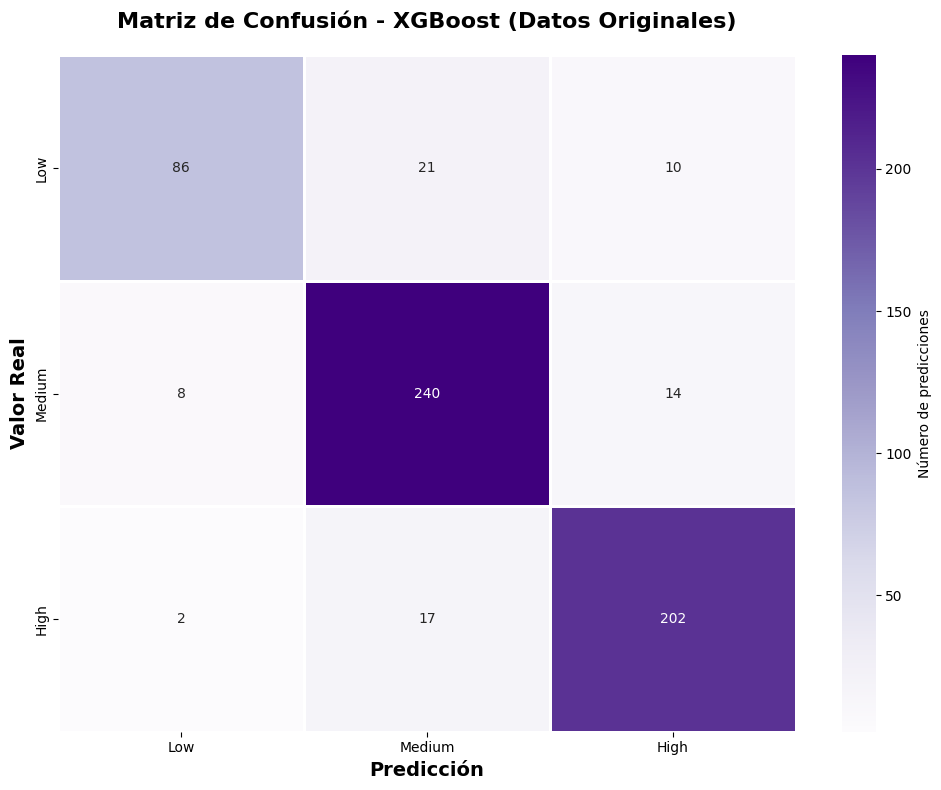

In [72]:
# Visualizamos los reultados obtenidos en una matriz de confusión

cm_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_xgb, annot=True, fmt='d',  cmap='Purples', linewidths=2, 
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'],
            cbar_kws={'label': 'Número de predicciones'})
plt.title('Matriz de Confusión - XGBoost (Datos Originales)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicción', fontsize=14, fontweight='bold')
plt.ylabel('Valor Real', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [77]:
# Dado Xgboost es un modelo de caja negra, es importante entender que features estan influyendo en las predicciones del modelo, para ello analizamos las importancias de las caracteristicas

# Feature Importance de XGBoost
feature_importance_xgb = xgb_model.feature_importances_
feature_names_xgb = X_train.columns

# Crear DataFrame con importancias
importance_df_xgb = pd.DataFrame({
    'Feature': feature_names_xgb,
    'Importance': feature_importance_xgb
}).sort_values(by='Importance', ascending=False)



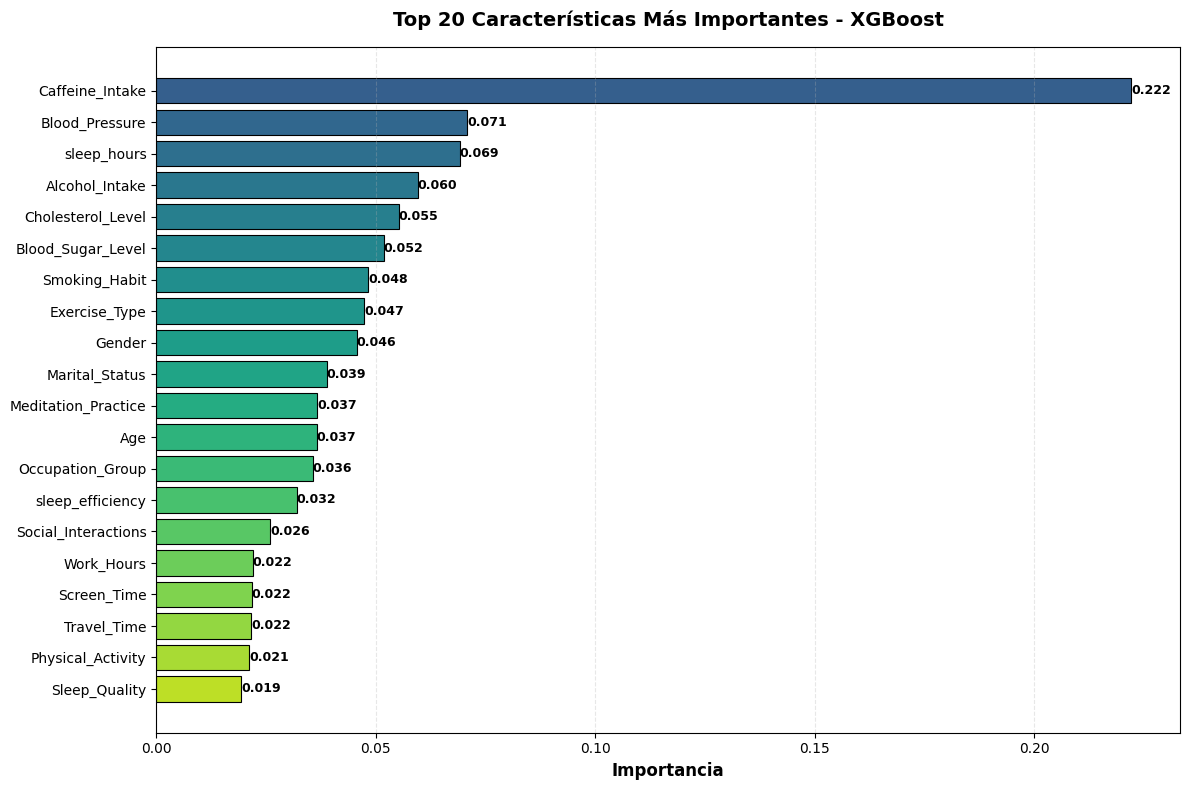


📊 TOP 20 CARACTERÍSTICAS MÁS IMPORTANTES:
 1. Caffeine_Intake                | 0.2221
 2. Blood_Pressure                 | 0.0708
 3. sleep_hours                    | 0.0691
 4. Alcohol_Intake                 | 0.0595
 5. Cholesterol_Level              | 0.0552
 6. Blood_Sugar_Level              | 0.0518
 7. Smoking_Habit                  | 0.0483
 8. Exercise_Type                  | 0.0473
 9. Gender                         | 0.0457
10. Marital_Status                 | 0.0388
11. Meditation_Practice            | 0.0367
12. Age                            | 0.0366
13. Occupation_Group               | 0.0356
14. sleep_efficiency               | 0.0320
15. Social_Interactions            | 0.0259
16. Work_Hours                     | 0.0220
17. Screen_Time                    | 0.0217
18. Travel_Time                    | 0.0217
19. Physical_Activity              | 0.0212
20. Sleep_Quality                  | 0.0193


In [100]:
# Visualización del Top 20 de características más importantes
top_20_features = importance_df_xgb.head(20)

# Crear gráfico
plt.figure(figsize=(12, 8))
colors_gradient = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_20_features)))
bars = plt.barh(top_20_features['Feature'], top_20_features['Importance'], 
                color=colors_gradient, edgecolor='black', linewidth=0.8)

# Añadir valores en las barras
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center', fontsize=9, fontweight='bold')

plt.xlabel('Importancia', fontsize=12, fontweight='bold')
plt.title('Top 20 Características Más Importantes - XGBoost', fontsize=14, fontweight='bold', pad=15)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# Mostrar tabla resumida
print("\n📊 TOP 20 CARACTERÍSTICAS MÁS IMPORTANTES:")
print("="*60)
for i, (_, row) in enumerate(top_20_features.iterrows(), 1):
    print(f"{i:2d}. {row['Feature']:30s} | {row['Importance']:.4f}")

## Implementanción de Randon Forest + GridSearchCV. La idea de entrear este modelo entrear el modelo mas optimo de RF y hacer un cuadro comparativo entre los modelos revisados



In [112]:
# Implementamos Grid Search para optimizar hiperparámetros del modelo Random Forest

rfc = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10, 20],  
    'min_samples_split': [2, 3, 5],  
    'min_samples_leaf': [1, 2, 3, 5],  # 
}

grid_search = GridSearchCV(
    estimator=rfc,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 150}
Best CV Score: 0.8850000000000001


In [113]:
# Evaluamos el modelo Random Forest con los mejores hiperparámetros encontrados
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.69      0.80       117
           1       0.85      0.94      0.89       262
           2       0.90      0.93      0.92       221

    accuracy                           0.89       600
   macro avg       0.90      0.85      0.87       600
weighted avg       0.89      0.89      0.88       600



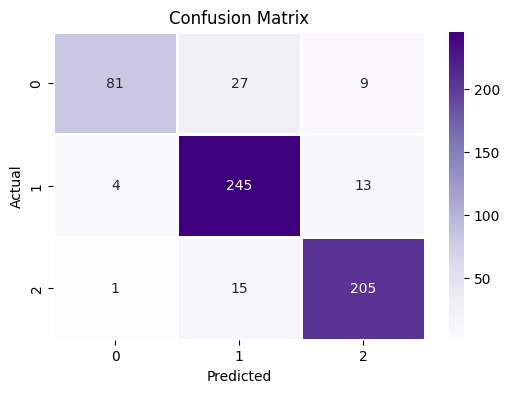

In [114]:
# Matriz de confusión para Random Forest

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', linewidths=2)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## RESULTADOS DE TODOS MODELOS SUPERVISADOS IMPLEMENTADOS.

In [120]:
# Creaamos tabla Camparativa de todos los modelos implementados

# Recopilar todas las métricas
models_comparison = {
    'Modelo': ['KNN (L1/uniform)', 'SVM (RBF)', 'XGBoost', 'Random Forest'],
    'Accuracy': [test_accuracy_knn, svm_best_accuracy, xgb_accuracy, accuracy_score(y_test, y_pred)],
    'Precision': [test_precision_knn, svm_best_precision, xgb_precision, precision_score(y_test, y_pred, average='macro')],
    'Recall': [test_recall_knn, svm_best_recall, xgb_recall, recall_score(y_test, y_pred, average='macro')],
    'F1-Score': [test_f1_knn, svm_best_f1, xgb_f1, f1_score(y_test, y_pred, average='macro')]
}

# crear DataFrame
df_comparison = pd.DataFrame(models_comparison)

# Mostrar tabla formateada
print("="*80)
print("📊 COMPARACIÓN DE RESULTADOS - TODOS LOS MODELOS")
print("="*80)
print(df_comparison.to_string(index=False))
print("="*80)

# Identificar el mejor modelo por métrica
print("MEJOR MODELO POR METRICA:")
print("-"*80)
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    best_idx = df_comparison[metric].idxmax()
    best_model = df_comparison.loc[best_idx, 'Modelo']
    best_value = df_comparison.loc[best_idx, metric]
    print(f"{metric:12s}: {best_model:20s} ({best_value:.4f})")


📊 COMPARACIÓN DE RESULTADOS - TODOS LOS MODELOS
          Modelo  Accuracy  Precision   Recall  F1-Score
KNN (L1/uniform)  0.906667   0.894839 0.889184  0.891865
       SVM (RBF)  0.900000   0.904029 0.878892  0.889294
         XGBoost  0.880000   0.884316 0.855033  0.866735
   Random Forest  0.885000   0.899534 0.851675  0.868580
MEJOR MODELO POR METRICA:
--------------------------------------------------------------------------------
Accuracy    : KNN (L1/uniform)     (0.9067)
Precision   : SVM (RBF)            (0.9040)
Recall      : KNN (L1/uniform)     (0.8892)
F1-Score    : KNN (L1/uniform)     (0.8919)


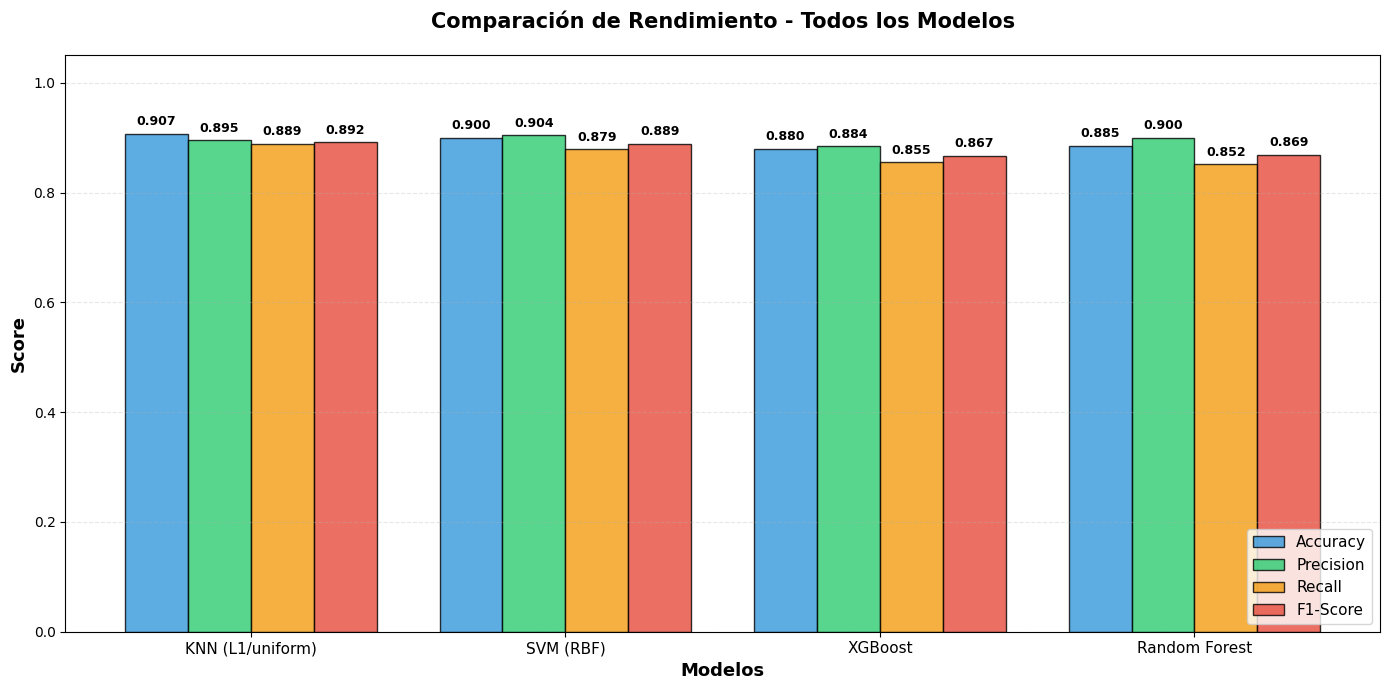

In [121]:
# Grafico de resultados metricas modelos

fig, ax = plt.subplots(figsize=(14, 7))

# Configuración de posiciones y ancho de barras
x = np.arange(len(df_comparison['Modelo']))
width = 0.2

# Colores para cada metri
colors = ['#3498db',  '#2ecc71', '#f39c12', '#e74c3c']
metrics = ['Accuracy',  'Precision', 'Recall',  'F1-Score']

# Crear barras por metrica
for i, (metric, color) in enumerate(zip(metrics, colors)):
    offset = width * (i - 1.5)
    bars = ax.bar(x + offset, df_comparison[metric], width, 
                   label=metric, color=color, alpha=0.8, edgecolor='black', linewidth=1)
    
    # añadimos valores 
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x()    + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Configuración del grafico
ax.set_xlabel('Modelos',  fontsize=13, fontweight='bold')
ax.set_ylabel('Score', fontsize=13, fontweight='bold')
ax.set_title('Comparación de Rendimiento - Todos los Modelos', fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels( df_comparison['Modelo'], fontsize=11)
ax.legend(loc='lower right', fontsize=11)
ax.set_ylim(0, 1.05)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()
